![/Images/skyline.jpg](Images/skyline.jpg)

# Predicting Housing Prices in King County, WA

## Overview and Business Problem

Buying a home can be a frustrating process. Everyone has some idea of their dream home, but when it comes down to actually buying one, chances are there are blockers to getting the exact one you want. Maybe the square footage isn't right, or you wish it had another bedroom, or you simply don't have enough cash on hand to cover the down payment. Whatever it is, the process is long and arduous and requires lots of research. Even after agreeing to terms with the seller, the closing process takes another 30 days typically, and could drain even more of your resources.

As a prospective home buyer, one of the last things you'd want to do is overpay for that home. You might not realize this right away - maybe you find out when you try to sell a few years later and no one wants to buy it for the price you paid - but you will know at some point, whether it be because of market conditions or the value you get out of it. It's hard to know when you're getting fleeced, especially when you're really desparate to buy. This project is meant to help buyers not overpay for their home. By building a reliable prediction engine, we can help new home buyers know if they're getting a good price. We'd also be able to tell them what factors influence prices, and by how much. In theory, waterfront property will be cost more, but by how much? Does a house that's been renovated have much higher prices than those that haven't? How about how old the house is, or the zipcode in which it was built?

All of these questions could provide really useful data to new home buyers, and help ensure they're getting a good deal. In turn, it might encourage them to pass on a home that is really overpriced when compared to the predicted price. The following will attempt to build a prediction engine that prospective home buyers can use when searching for ideal home. In the future, this model can be used as the backbone for an app or website, in which you can input the information of a house that is on sale, predict what the market price should be, and compare it to listings across the internet on sites like zillow.

## Data Understanding

The data in this project comes from King County of Washington State. The county includes both Seattle and Bellevue, so we're looking at a large number of houses - over 21K. The dependent variable in this analysis will be home prices.

That's an exceedingly large sample and should be robust enough to find reasonable conclusions about housing trends in the county. One issue that we'll inevitably run into is hidden variable bias. The variables in this dataset simply cannot be all of the factors that influence housing prices. Factors like proximity to schools, number of grocery stores, walkability of the neighborhood, and many others are not going to be captured in this model, limiting it somewhat. However, I will try to build the most robust model I can given the data we have to work with.

To help predict the price, we will be using the following explanatory variables:

- Rooms
- Square footage in each house, and the square footage of the houses' 15 closest neighbors
- Year built
- Year renovated (if applicable)
- Condition (overall condition of the house)
- Grade (overall grade given to each house by the King County Grading System)
- Zipcode
- Latitude and longitude

Using these variables, and others I create, I will attempt to create a quality model (defined by satisfying the assumptions of linear regression, a high R2, and a low root mean squared error) that can accurately predict the price of a house and also provide clarity into how different variables affect the price.

In [1]:
# First, my library imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import metrics

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

from yellowbrick.regressor import ResidualsPlot

import eli5

from geopy import distance

import warnings
warnings.filterwarnings("ignore")

C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import the data
df = pd.read_csv('data/kc_house_data.csv')

#explore the first 5 rows

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Let's explore the relationships between some of the X variables and price, our Y variable, in a pairplot.

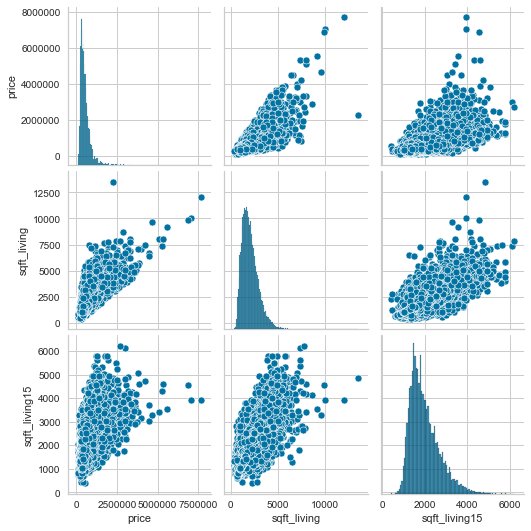

In [4]:
#breaking this into three pairplots because outputs are hard to read with a large plot
cols_to_use = ['price', 'sqft_living', 'sqft_living15']
sns.pairplot(df[cols_to_use])

We see a linear relationship between price, sqft_living, and sqft_living15 above.

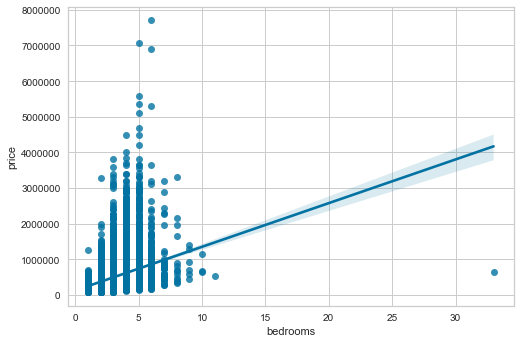

In [5]:
sns.regplot(x='bedrooms', y='price', data=df)

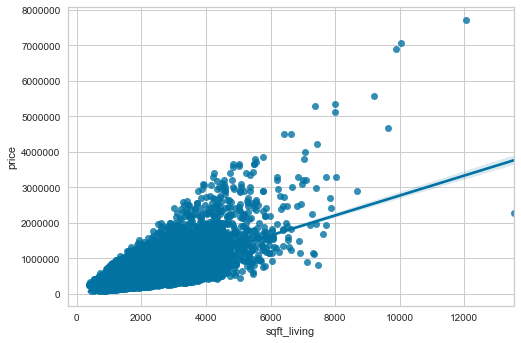

In [72]:
sns.regplot(x='sqft_living', y='price', data=df)

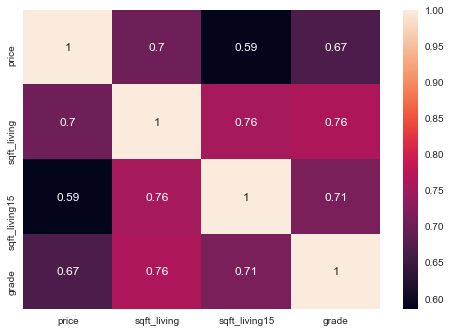

In [76]:
# cols_to_use = ['price', 'sqft_living', 'sqft_living15','grade']
# sns.heatmap(df[cols_to_use].corr(), center=0, annot=True);

ax = sns.heatmap(df[cols_to_use].corr(), annot=True);
# need to manually set my ylim because of my version of matplotlib
ax.set_ylim(4, 0)
plt.show()

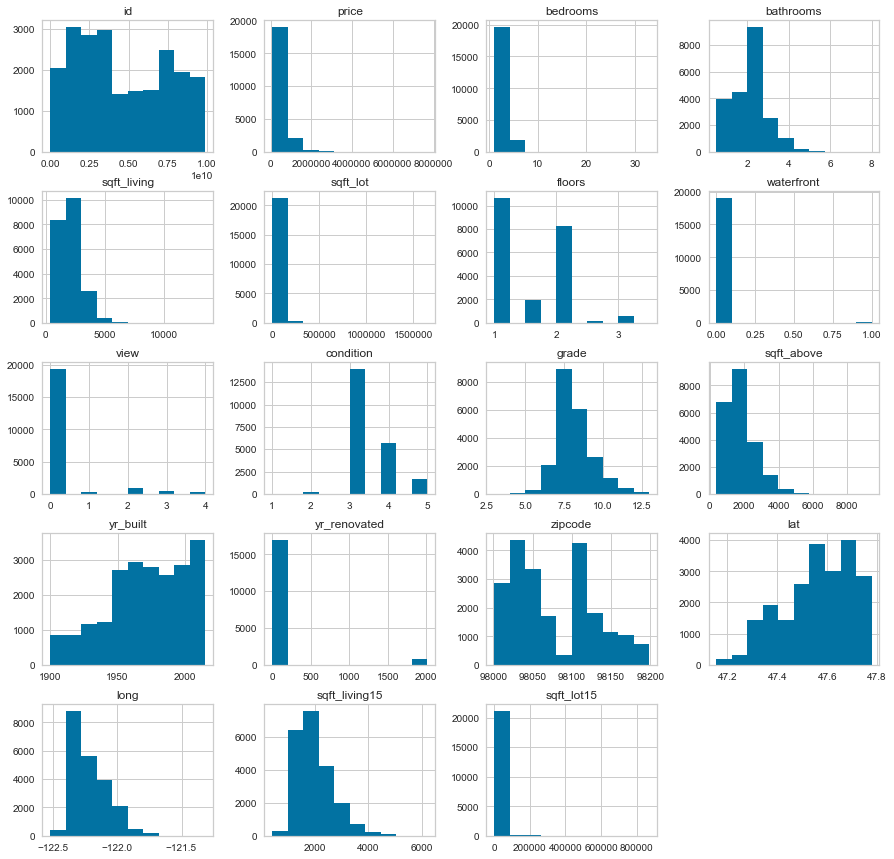

In [6]:
#and let's get an idea of the distributions again
df.hist(figsize=[15,15]);

The variables above all appear to be heavily skewed. This should be corrected in the data preparation stage. It also looks like sqft_lot and bedrooms don't have much of a linear relationship with price - these wouldn't help our model to predict price.

Now for the next set of variables:

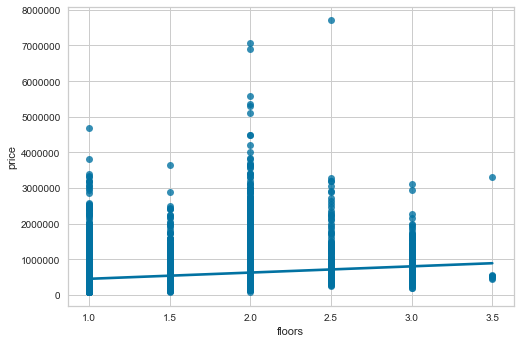

In [7]:
sns.regplot(x='floors', y='price', data=df)

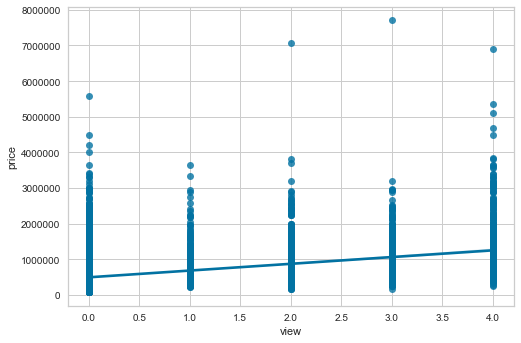

In [8]:
sns.regplot(x='view', y='price', data=df)

It's hard to make out an discernable relationship between price and floors or price and view. It's difficult to gauge for waterfront because it's simply a dummy variable, but grade and condition do appear to have some relationship with price. These are worth exploring further.

Last set of variables:

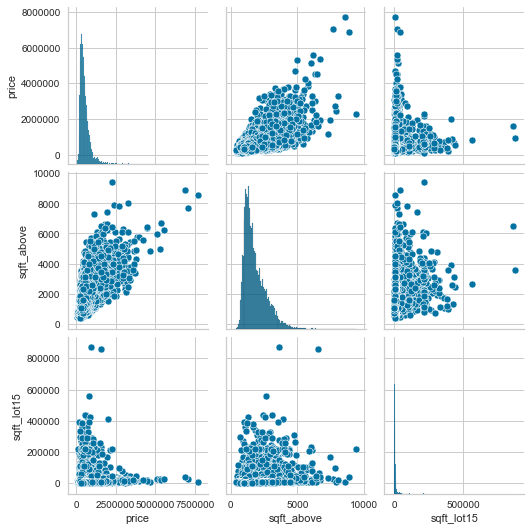

In [9]:
#zipcode and lat/long aren't worth graphing at this stage - the numbers in zipcode are meaningless and latitude and longitude
#don't make much sense to explore on their own since they represent one place together
cols_to_use = ['price', 'sqft_above', 'sqft_basement','sqft_lot15']
sns.pairplot(df[cols_to_use])

Once again, we see heavily skewed data that will need to be addressed. We see a linear relationship between price and sqft_above (the square footage not including the basement) above. Sqft_lot15 doesn't look like it will be too useful, while yr_built and yr_renovated should be explored more because it is likely there is some relationship with price.

Below, we have a box and whiskers plot to show us how our outliers looks for our numeric variables

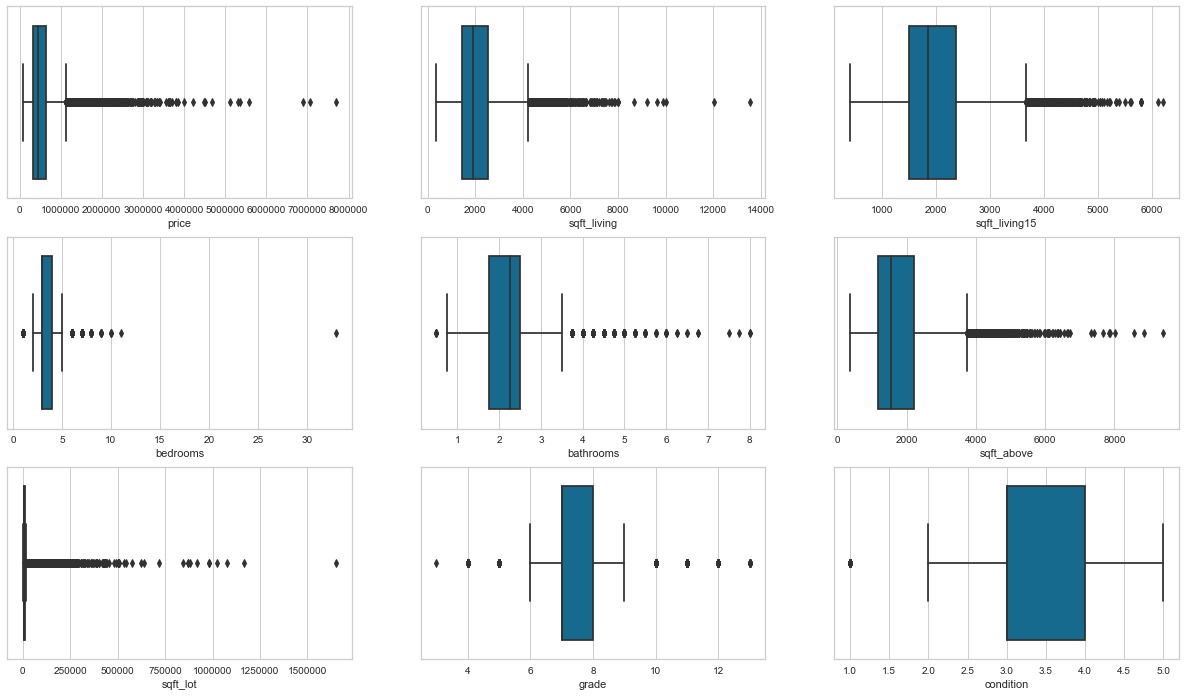

In [10]:
num_vars = ['price','sqft_living', 'sqft_living15', 'bedrooms', 'bathrooms', 'sqft_above', 
            'sqft_lot', 'grade', 'condition']
def plot_univariate_panel(vars_name, data, func_plot, n_cols=2):
    
    from math import ceil
    
    n_rows = ceil(len(vars_name) / n_cols)
    
    plt.figure(figsize=(7 * n_cols, 4 * n_rows))
    for idx, var in enumerate(vars_name, 1):
        plt.subplot(n_rows, n_cols, idx)
        func_plot(data[var])

plot_univariate_panel(num_vars, df, sns.boxplot, 3)

We definitely have a pretty large outlier problem that will need to be addressed during data preparation

Finally, let's look at our price variable:

In [11]:
df['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [12]:
for i in range(75,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.75 percentile: 645000.0
0.76 percentile: 652500.0
0.77 percentile: 665000.0
0.78 percentile: 677755.2000000003
0.79 percentile: 690000.0
0.8 percentile: 700435.9999999998
0.81 percentile: 718000.0
0.82 percentile: 730000.72
0.83 percentile: 749950.0
0.84 percentile: 760003.2
0.85 percentile: 779721.9999999991
0.86 percentile: 799000.0
0.87 percentile: 815000.0
0.88 percentile: 836739.9999999998
0.89 percentile: 859967.6
0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


The cheapest house is 78K while the most expensive 7.7m. This range could be really problematic and confirms what we're seeing in the box plots above. It's even substantially above the 99th percentile (1.97m).

This dataset contains 21,597 houses. We only see null values for waterfront, which is our one pure dummy variable (1 for waterfront, 0 for anything else) and year renovated. For the purposes of these models, I will assume that a null implies that the house is not on waterfront property or that it hasn't been renovated - meaning I will fill in zeros for those nulls.

We also have a few categorical variables with ordinal relationships. These variables are:

- Grade (3-13)
- Condition (1-5)
- Bedrooms (1-33 - an outlier value)
- Bathrooms (.5-7.5)
- Floors (1-3.5)
- View (0-4)

Year built and year renovated could also be considered ordinal categorical variables. I will transform these years into an age column, which will be treated as a continuous variable.

In general, there are two ways to treat these categorical variables. One way is to assign dummy values to each category. A drawback of this method is that you lose the meaning of the variable's ordinality, and treat the difference between each category as equal (The difference between a grade 3 and a grade 4 house is the same as the difference between a grade 7 and a grade 8 house). This might not be true in reality. The other method is to treat it essentially as a continuous variable. This allows for proper interpretation of the variable's ordinality. However, the variables are obviously not truly continuous, and treating them as such can have negative impacts on the quality of your predictions.

For the ordinal variables I use, I will treat them both ways in separate models to compare their effects.

In the next section, I will clean and prepare the data. I will also create and drop some variables to develop the best model I can.

## Data Preparation

Below, I'll begin preparing my data for modeling. The main task will be to first remove outliers and drop columns we won't be using.

In [13]:
#First, create a copy of the dataframe so we can preserve the original dataset

df2 = df.copy()

# cleaning up columns and removing columns

def data_clean(df):
    #fill N/As with 0s
    df.fillna(0, inplace=True)

    #first, I'm converting waterfront and yr_renovated to integers
    df['waterfront'] = df['waterfront'].astype('int64')
    df['yr_renovated'] = df['yr_renovated'].astype('int64')


    #next, I'm eliminating price and square foot outliers
    df.drop(df[(df['price'] < 100000) | (df['price'] > 1000000)].index, inplace=True)
    df.drop(df[df['sqft_living'] > 4000].index, inplace=True)
    df.drop(df[df['sqft_living15'] > 3500].index, inplace=True)


    #choosing columns to drop based on multicollinearity and relationship to price
    #sqft_above and basement are clearly correlated with sqft_living, so those make sense to remove
    #id and date don't provide us any useful information

    #view, floors, sqft_lot, sqft_lot15, and bedrooms don't have much of a relationship with price
    #bathrooms will be correlated with price
    #leaving in lat and long for later, will remove in df2 separately
    df.drop(columns = ['id', 'date', 'zipcode', 'sqft_basement', 'sqft_above', 'view', 
                       'floors', 'sqft_lot', 'sqft_lot15', 'bedrooms'], inplace=True)
    df.head()

In [14]:
#leaving in zipcode for later use

def data_clean_zip(df):
    '''
    Input: Pandas dataframe: df
    Output: cleaned df with the below parameters
    '''
    #fill N/As with 0s
    df.fillna(0, inplace=True)

    #first, I'm converting waterfron and yr_renovated to integers
    df['waterfront'] = df['waterfront'].astype('int64')
    df['yr_renovated'] = df['yr_renovated'].astype('int64')
    #df['bathrooms'] = df['bathrooms'].astype('int64')


    #next, I'm eliminating price and square foot outliers
    df.drop(df[(df['price'] < 100000) | (df['price'] > 1000000)].index, inplace=True)
    df.drop(df[df['sqft_living'] > 4000].index, inplace=True)
    df.drop(df[df['sqft_living15'] > 3500].index, inplace=True)


    #choosing columns to drop based on multicollinearity and relationship to price
    #sqft_above and basement are clearly correlated with sqft_living, so those make sense to remove
    #id and date don't provide us any useful information

    #view, floors, sqft_lot, sqft_lot15, and bedrooms don't have much of a relationship with price
    #bathrooms will be correlated with price
    #leaving in lat and long for later, will remove in df2 separately
    df.drop(columns = ['id', 'date', 'sqft_basement', 'sqft_above', 'view', 
                       'floors', 'sqft_lot', 'sqft_lot15', 'bedrooms'], inplace=True)
    df.head()

In [15]:
df2.drop(columns=['lat','long'])
data_clean(df2)

In [16]:
#to inspect the percentage of data lost by removing outliers
data_loss = ((21596 - len(df2))/21596)*100
print("We've lost:", round(data_loss), "%", "of our data" )

We've lost: 9 % of our data


### First $&(@# Model

Before completing more data prep, let's use our exisiting variables leftover to create a substandard model to create a baseline moving forward.

This model will have no logging or scaling, it will simply treat the variables as they are.

First let's check our multicollinearity using Variance Inflation Factor (VIF)

In [17]:
def vif(df):
    '''
    Input: Pandas dataframe: df
    Output: A dataframe of VIF scores
    
    Variance inflation factor is a function from the statsmodels library.
    Rather than a correlation matrix, which tells you how correlated a pair of variables are,
    VIF is a wholistic metric that describes how correlated one feature is with all others.
    Anything over 5 is considered highly collinear.
    '''
    X_cols = [c for c in df.columns.to_list() if c not in ['price', 'price_log']]
    X = df[X_cols]
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['features'] = X.columns
    return vif

In [18]:
vif(df2)

,VIF,features
0,24.380275,bathrooms
1,28.209260,sqft_living
2,1.010292,waterfront
3,33.612188,condition
4,139.104434,grade
5,8159.300949,yr_built
6,1.125065,yr_renovated
7,112591.859069,lat
8,125212.505720,long
9,28.576754,sqft_living15


Any VIF score above 5 means that the variable is highly correlated to the other variables. This makes their coefficients extremely unreliable. This will be a bad model, but it's a good place to start.

In [19]:
def linear_regression(df):
    '''
    Input: Pandas dataframe
    Output: multiple linear regression results (R2, RMSE) for train and test sets,
    residual scatter plot and histogram, list of variables and their coefficients
    '''
    
    X_cols = [c for c in df.columns.to_list() if c not in ['price', 'price_log']]
    X = df[X_cols]
    y = df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    y_pred_train_unlog = np.expm1(y_pred_train)
    y_pred_test_unlog = np.expm1(y_pred_test)
    
    y_train_unlog = np.expm1(y_train)
    y_test_unlog = np.expm1(y_test)

    coef = dict(zip(X.columns, lr.coef_))
    coef = pd.DataFrame.from_dict(coef, orient='index')
    coef.rename(columns={0: "coefficient"}, inplace=True)

    print(f"Train Score: {r2_score(y_train, y_pred_train)}")
    print(f"Test Score: {r2_score(y_test, y_pred_test)}")
    print('---')

    print('Train RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print('Test RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print('---')
    
    if np.isfinite(y_train_unlog).any() == False:
        pass
    else:
        print('Unlogged Train RMSE: ', np.sqrt(metrics.mean_squared_error(y_train_unlog, y_pred_train_unlog)))
        print('Unlogged Test RMSE: ', np.sqrt(metrics.mean_squared_error(y_test_unlog, y_pred_test_unlog)))
    print('---')
    
    print('Intercept: ', lr.intercept_)
    
    visualizer = ResidualsPlot(lr, hist=True, qqplot=False)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()      

    return coef

Train Score: 0.652161198098523
Test Score: 0.6623916304176145
---
Train RMSE:  112216.86162308877
Test RMSE:  110609.08944538591
---
---
Intercept:  -22229800.018923502


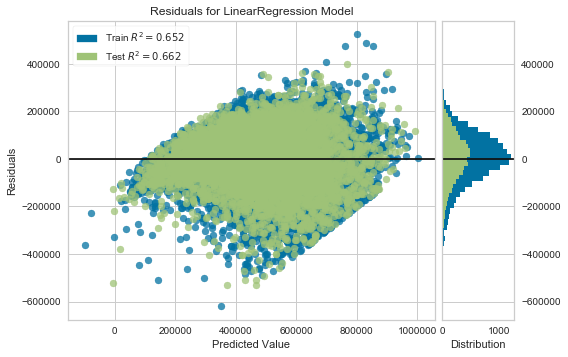

,coefficient
bathrooms,26152.822865
sqft_living,65.588031
waterfront,256823.600187
condition,22748.512191
grade,77328.800720
yr_built,-1622.241869
yr_renovated,17.476789
lat,521273.843177
long,-1406.026238
sqft_living15,48.706671


In [20]:
linear_regression(df2)

This model has an okay R2 of .653 for the training data, and an R2 of .658 on the test data, which means the data is fit fairly well. However, we're still dealing with non-normal data and a lot of structural multicollinearity. This is a good baseline to improve upon going forward.

In [21]:
#lets create another copy of the dataframe to leave the baseline model as is

df3 = df.copy()

#to capture the latest year a house was built (either the original built date, or if it was renovated, the renovation date),
#I'm creating a column called "renovated", which takes a 1 if there is a date in the yr_renovated column, and a 0 if there
#is a 0 in the column.

def add_years_col(df):
    df['renovated'] = df['yr_renovated']
    for year in df['renovated']:
        if year != 0:
            df['renovated'].replace(year, 1, inplace=True)
        else:
            df['renovated'].replace(year, 0, inplace=True)

    #changing yr_renovated to take the year built if it hasn't been renovated. 
    #this will allow for easy calculation for years old
    #which will subtract the year built or renovated, whichever is later, from 2020.
    df['yr_renovated'] = df[['yr_renovated', 'yr_built']].apply(lambda pair: pair[0] if pair[0] != 0 else pair[1], axis=1)

    #number of years since built/renovated col:
    df['years_old'] = 2020 - df['yr_renovated']

    #now remove yr_built because it becomes redundant
    df.drop(columns = ['yr_built', 'yr_renovated'], inplace=True)

    return df.head()


data_clean(df3)
df3.drop(columns=['lat','long'])
add_years_col(df3)

,price,bathrooms,sqft_living,waterfront,condition,grade,lat,long,sqft_living15,renovated,years_old
0,221900.0,1.00,1180,0,3,7,47.5112,-122.257,1340,0,65
1,538000.0,2.25,2570,0,3,7,47.7210,-122.319,1690,1,29
2,180000.0,1.00,770,0,3,6,47.7379,-122.233,2720,0,87
3,604000.0,3.00,1960,0,5,7,47.5208,-122.393,1360,0,55
4,510000.0,2.00,1680,0,3,8,47.6168,-122.045,1800,0,33


## Modeling

The following section will detail the modeling process, and each model will iteratively build on the last based on its effectiveness.

### Model #2

In model #2, I've used the year built and year renovated columns to create a new column called "years_old." Rather than dealing with the actual year, it'll be easier to interpret our results if we have an easy to read column of how old the house is.

I've also added a column named "renovated," which indicates whether a house has been renovated with a 1 or 0. The columns representing the actual year built and year renovated have been removed because they would be correlated with the renovated and years_old column.

We will also leave condition and grade as is, choosing to treat them like continuous variables for now.

In [22]:
#first, let's check our multicollinearity problems

vif(df3)

,VIF,features
0,24.749915,bathrooms
1,28.293895,sqft_living
2,1.010411,waterfront
3,33.989504,condition
4,140.941625,grade
5,113237.738091,lat
6,112266.472290,long
7,28.431071,sqft_living15
8,1.077926,renovated
9,7.326014,years_old


To address this multicollinearity, I will log and scale my continuous variables, and scale all variables except waterfront and renovated. These are 0-1 dummy variables, so scaling or logging them would remove their meaning as a "yes" or "no" variable.

Scaling helps remove structural multicollinearity by centering the variable's distribution around a mean of 0. It's also useful for interpretation because now we can compare variables that previously had much different magnitudes and units.

In [23]:
df3.head()

,price,bathrooms,sqft_living,waterfront,condition,grade,lat,long,sqft_living15,renovated,years_old
0,221900.0,1.00,1180,0,3,7,47.5112,-122.257,1340,0,65
1,538000.0,2.25,2570,0,3,7,47.7210,-122.319,1690,1,29
2,180000.0,1.00,770,0,3,6,47.7379,-122.233,2720,0,87
3,604000.0,3.00,1960,0,5,7,47.5208,-122.393,1360,0,55
4,510000.0,2.00,1680,0,3,8,47.6168,-122.045,1800,0,33


In [24]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

#logging all continuous/ordinal variables which have non-normal distributions

to_log = ['price', 'sqft_living', 'sqft_living15', 'condition', 'grade', 'bathrooms', 'years_old']
cats = ['waterfront', 'renovated',]
price = ['price_log']

def preprocessing(df, log_vars, categoricals, price):
    '''
    Input:
    - Pandas dataframe
    - list of variables to log
    - list of variables to normalize
    - list of dummy variables to not normalize
    - list containing 'price'
    Output: A new dataset called 'preprocessed' with logged and normalized variables,
    ready to be inserted into the linear regression function
    '''
    
    df_log_names = df[log_vars]
    log_names = [f'{column}_log' for column in df_log_names.columns]
    df_log = np.log(df_log_names)
    df_log.columns = log_names
        

    price_df = df_log[price]
    norm = df_log.copy()
    norm.drop(columns='price_log', inplace=True)
    norm_vars = norm.apply(normalize)
    no_norm = df[categoricals]

    #new_log_norm = new_log.apply(normalize)

    preprocessed = pd.concat([price_df, norm_vars, no_norm], axis=1)
    return preprocessed

In [25]:
preprocessed = preprocessing(df3, to_log, cats, price)
preprocessed.head()

,price_log,sqft_living_log,sqft_living15_log,condition_log,grade_log,bathrooms_log,years_old_log,waterfront,renovated
0,12.309982,-1.097201,-1.002918,-0.618068,-0.429184,-1.691557,0.714366,0,0
1,13.195614,0.965207,-0.208244,-0.618068,-0.429184,0.466800,-0.371306,0,1
2,12.100712,-2.228251,1.421465,-0.618068,-1.621172,-1.691557,1.106510,0,0
3,13.311329,0.247274,-0.952185,2.204349,-0.429184,1.232489,0.489651,0,0
4,13.142166,-0.161160,0.007696,-0.618068,0.603362,0.153311,-0.197495,0,0


In [26]:
preprocessed['price_log'].describe()

count    19660.000000
mean        12.953333
std          0.425193
min         11.512925
25%         12.644328
50%         12.969212
75%         13.270783
max         13.815511
Name: price_log, dtype: float64

Before running our regression, let's see if the logging and scaling treatment fixed our multicollinearity:

In [27]:
vif(preprocessed)

,VIF,features
0,3.367616,sqft_living_log
1,2.113390,sqft_living15_log
2,1.192442,condition_log
3,2.230468,grade_log
4,2.749248,bathrooms_log
5,1.892735,years_old_log
6,1.004447,waterfront
7,1.050349,renovated


All of our variables now have a VIF of below 5, meaning we teased out harmful multicollinearity. Let's run our regression and see what we get:

Train Score: 0.4479516554680779
Test Score: 0.45469648783076344
---
Train RMSE:  0.31409027658024125
Test RMSE:  0.3176137429080164
---
Unlogged Train RMSE:  140504.85981259344
Unlogged Test RMSE:  142561.17981302363
---
Intercept:  12.943857119914298


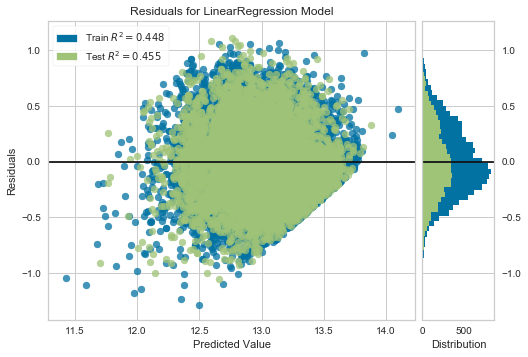

,coefficient
sqft_living_log,0.079149
sqft_living15_log,0.064068
condition_log,0.025350
grade_log,0.185269
bathrooms_log,0.028850
years_old_log,0.089115
waterfront,0.399367
renovated,0.285458


In [28]:
linear_regression(preprocessed)

Our R2 got worse here - it's under .5, but we have reduced multicollinearity across the board, so our next task will be to continue to add and transform variables.

Next, let's use put our geographic data to use.

### Model #3

In [29]:
def add_distance_col(df):
    '''
    This function uses the Python library geopy to calculate the distance from each house to downtown Seattle, in miles.
    Input: df=dataframe
    Output: a column called "distance_downtown," which is how far a house is in miles from downtown
    '''
    seattle_downtown = (47.603230, -122.330280)

    location = []
    for x, y in zip(df.lat, df.long):
        location.append((x,y))

    df['location'] = location

    df.reset_index(inplace=True)
        
    distance_from_downtown = []
    for x in range(len(df)):
        distance_from_downtown.append(distance.distance(seattle_downtown, df['location'][x]).miles)

    df['distance_downtown'] = distance_from_downtown

    #let's leave in sqft_living15 for now
    df.drop(columns=['lat', 'long', 'location', 'index'], inplace=True)
    df.head()

In [30]:
df4 = df.copy()

In [31]:
data_clean(df4)
add_years_col(df4)
add_distance_col(df4)

In [32]:
df4.head()

,price,bathrooms,sqft_living,waterfront,condition,grade,sqft_living15,renovated,years_old,distance_downtown
0,221900.0,1.00,1180,0,3,7,1340,0,65,7.222676
1,538000.0,2.25,2570,0,3,7,1690,1,29,8.153317
2,180000.0,1.00,770,0,3,6,2720,0,87,10.352261
3,604000.0,3.00,1960,0,5,7,1360,0,55,6.405557
4,510000.0,2.00,1680,0,3,8,1800,0,33,13.360759


Before we move on, let's see how square footage and distance from downtown relate. We would expect houses to get bigger as they move farther away, which is something a prospective home buyer may want to factor in

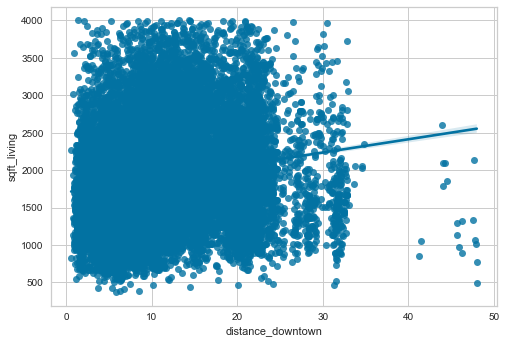

In [33]:
sns.regplot(x='distance_downtown', y='sqft_living', data=df4)

Surprisingly, there is a very small upward trend, but in general, there doesn't appear to be much of a relationship.

In [34]:
to_log = ['price', 'sqft_living', 'sqft_living15', 'grade', 'years_old', 'bathrooms', 'condition','distance_downtown']
vars_no_norm = ['waterfront', 'renovated']
price = ['price_log']

In [35]:
preprocessed = preprocessing(df4, to_log, vars_no_norm, price)

Train Score: 0.6184766004604489
Test Score: 0.6281943036513454
---
Train RMSE:  0.26365568038219533
Test RMSE:  0.25717363039384095
---
Unlogged Train RMSE:  118707.624310672
Unlogged Test RMSE:  116058.43343565131
---
Intercept:  12.947306572302884


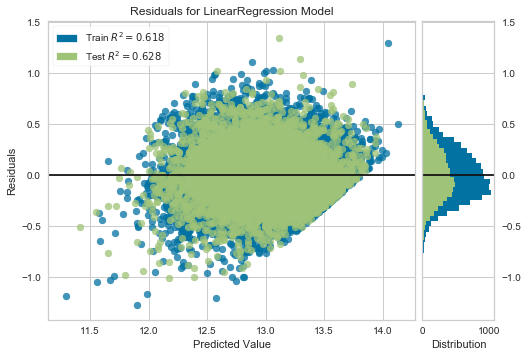

,coefficient
sqft_living_log,0.120990
sqft_living15_log,0.107276
grade_log,0.130471
years_old_log,0.023436
bathrooms_log,0.006349
condition_log,0.039283
distance_downtown_log,-0.191103
waterfront,0.444242
renovated,0.134758


In [36]:
linear_regression(preprocessed)

Adding in the distance from downtown really boosted the R2 value to .634 and .627 for the training and testing samples respectively. We still have some overfitting on the training date. We also see a large reduction in the RMSE, which falls to .26 from .31.

Based on our residuals plot, we are dealing with significant heteroscedasticity, but our data does appear to be mostly normal. Let's check to see if we have any remaining outliers.

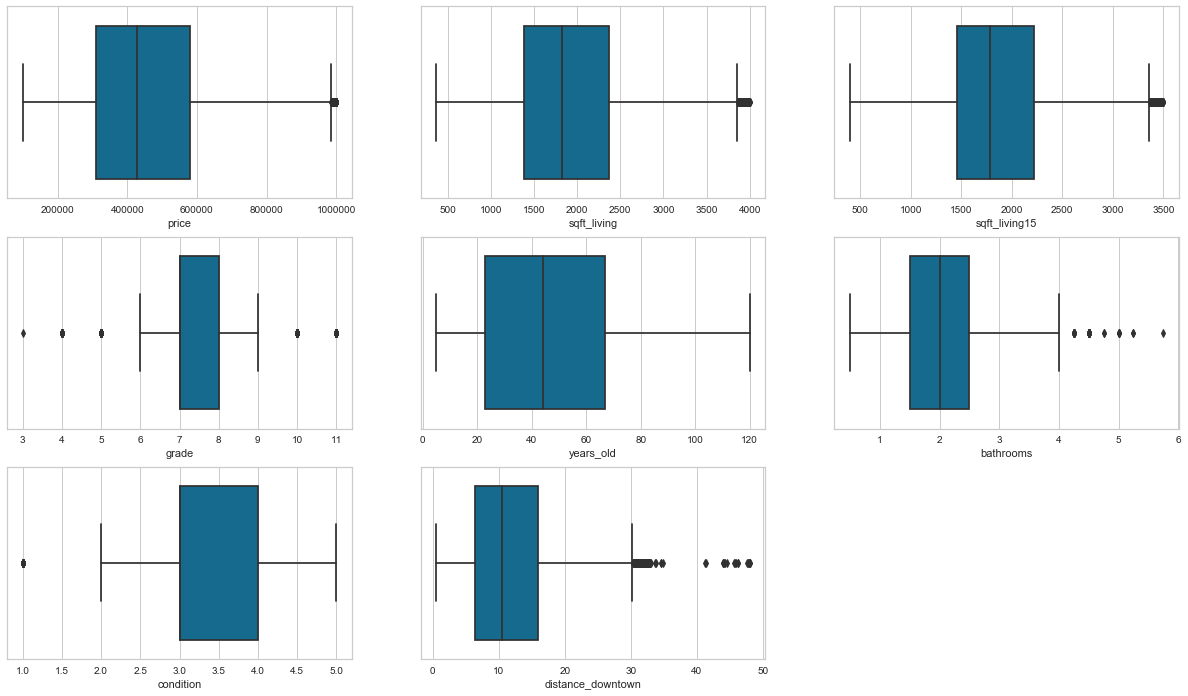

In [37]:
df5 = df.copy()
data_clean(df5)
add_years_col(df5)
add_distance_col(df5)
plot_univariate_panel(to_log, df5, sns.boxplot, 3)

We have some outliers in the distance_downtown and bathroom variables, let's see how many houses are outliers in their distance from downtown.

In [38]:
far_houses = df5[df5['distance_downtown']>30]
close_houses = df5[df5['distance_downtown']<=30]

print('Avg. price of a far house:', far_houses['price'].mean())
print('Avg. price of a close house:', close_houses['price'].mean())

Avg. price of a far house: 301395.70535714284
Avg. price of a close house: 462527.90064828156


As we expected, closer houses are more expensive on average than houses farther away from downtown. Most houses look to be between 0 and 35 miles away from downtown Seattle. Perhaps we should remove those farther than 40 miles away as they might be skewing the sample. Let's check how many there are.

In [39]:
really_far_houses = df5[df5['distance_downtown']>40]

print('The number of houses 40 or miles away from downtown is:', really_far_houses['price'].count())

The number of houses 40 or miles away from downtown is: 18


As there are only 18 houses that far away, we should remove them because it won't have a significant impact on sample size and could prove beneficial to our predictions. Let's drop those houses and see if our model improves at all.

In [40]:
df5.drop(df5[df5['distance_downtown'] > 40].index, inplace=True)

to_log = ['price', 'sqft_living', 'sqft_living15', 'grade', 'years_old', 'bathrooms', 'condition', 'distance_downtown']
vars_no_norm = ['waterfront', 'renovated']
price = ['price_log']

Train Score: 0.6201157901204067
Test Score: 0.6222413947934492
---
Train RMSE:  0.26153643007604316
Test RMSE:  0.2615345418624858
---
Unlogged Train RMSE:  117736.58660143922
Unlogged Test RMSE:  117594.69983589633
---
Intercept:  12.950381095992244


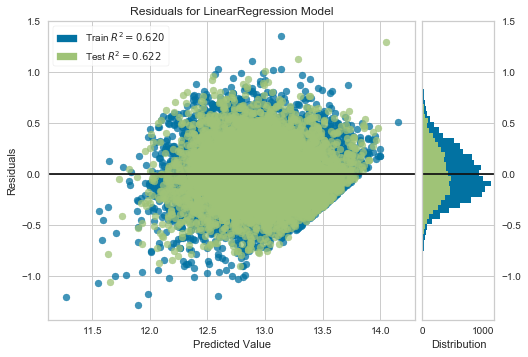

,coefficient
sqft_living_log,0.128123
sqft_living15_log,0.103736
grade_log,0.131845
years_old_log,0.026200
bathrooms_log,0.002276
condition_log,0.036202
distance_downtown_log,-0.191156
waterfront,0.426757
renovated,0.133665


In [41]:
preprocessed = preprocessing(df5, to_log, vars_no_norm, price)
linear_regression(preprocessed)

There's not really much of a difference in the model but I'll keep the houses removed.

### Model #4a

For model 4, I'll be creating groupings for grade, condition, and bathrooms. These are categorical variables, and I want to see if the model improves when treating them like categorical variables rather than continuous, as I've been doing thus far.

There are two ways to do this. One, is to create a separate dummy variable for each category (grade_1, grade_2, condition_1, condition_2, etc.). The 2nd way is to group the variables in bins, and assign each bin a 0 or 1.

We'll try individual dummy variable method first.

In [42]:
df6 = df.copy()

data_clean(df6)
add_years_col(df6)
add_distance_col(df6)

df6.drop(df6[df6['distance_downtown'] > 40].index, inplace=True)

to_log = ['price', 'sqft_living', 'sqft_living15', 'years_old', 'distance_downtown']
vars_no_norm = ['waterfront', 'renovated', ]
price = ['price_log']

df6['bathrooms'] = df6['bathrooms'].astype('int64')
one_hot_grade = pd.get_dummies(df6['grade'], prefix='grade', drop_first=True) 
one_hot_cond = pd.get_dummies(df6['condition'], prefix='cond', drop_first=True) 
one_hot_bath = pd.get_dummies(df6['bathrooms'], prefix='bath', drop_first=True) 

df6.drop(columns=['grade', 'condition', 'bathrooms'], inplace=True)

preprocessed = preprocessing(df6, to_log, vars_no_norm, price)
preprocessed = pd.concat([preprocessed, one_hot_grade, one_hot_cond, one_hot_bath], axis=1)
preprocessed.head()

,price_log,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,...,grade_11,cond_2,cond_3,cond_4,cond_5,bath_1,bath_2,bath_3,bath_4,bath_5
0,12.309982,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,13.195614,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,12.100712,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3,13.311329,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,13.142166,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


Train Score: 0.6250938264350445
Test Score: 0.6255867107988973
---
Train RMSE:  0.26057242767539723
Test RMSE:  0.25876025088812454
---
Unlogged Train RMSE:  117421.52079076132
Unlogged Test RMSE:  118073.94140117327
---
Intercept:  12.901248844747448


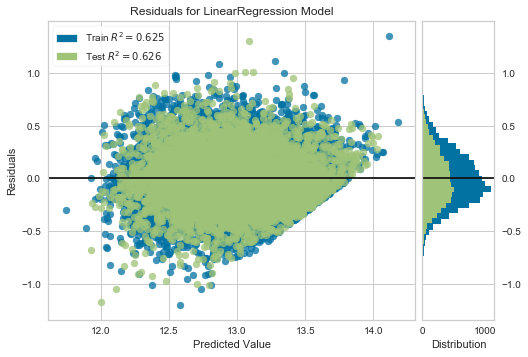

,coefficient
sqft_living_log,0.121249
sqft_living15_log,0.101699
years_old_log,0.029455
distance_downtown_log,-0.189166
waterfront,0.441750
renovated,0.151715
grade_4,-0.503475
grade_5,-0.534718
grade_6,-0.482846
grade_7,-0.332436


In [43]:
linear_regression(preprocessed)

Adding in these dummies in this way has definitely improved our R2 and our RMSE, but we still have a slight underfit and heteroscedasticity problem.

For the next model, instead of a dummy for each level, I'll group the variables and assign 1 or 0 to the groupings.

### Model #4b

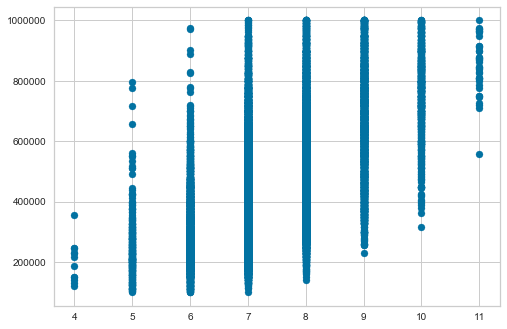

In [44]:
df7 = df.copy()

data_clean(df7)
add_years_col(df7)
add_distance_col(df7)

df7.drop(df7[df7['distance_downtown'] > 40].index, inplace=True)
df7['bathrooms'] = df7['bathrooms'].astype('int64')
df7.drop(df7[(df7['bathrooms'] < 1) | (df7['bathrooms'] > 5)].index, inplace=True)
df7.drop(df7[df7['grade'] < 4].index, inplace=True)
plt.scatter(df7['grade'], df7['price'])

#below, let's take a look at how our categorical variables are grouped when graphed against price

In [45]:
#Grade looks to have about 3 distinct tiers:
    # 4-5 have much lower prices on average
    # 6-8 have roughly the same kind of ditribution
    # 9-11 have much higher prices on average and definitely lead to price increases

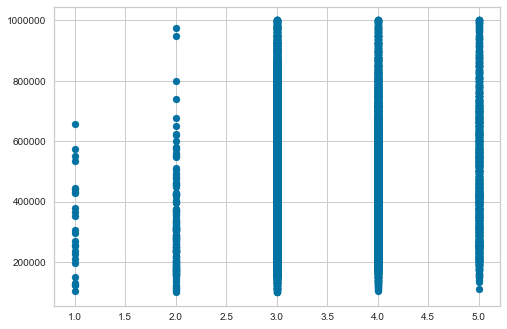

In [46]:
plt.scatter(df7['condition'], df7['price'])

In [47]:
#Condition appears to have two main groups: 1-2 and 3-5

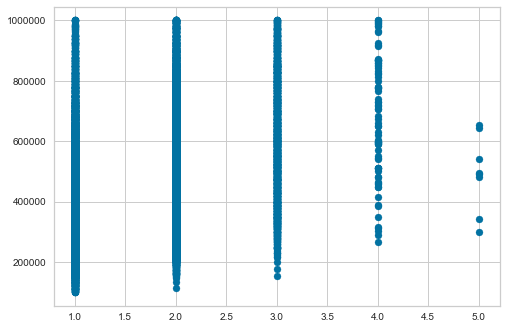

In [48]:
plt.scatter(df7['bathrooms'], df7['price'])

In [49]:
#Let's still one hot bathrooms

In [50]:
for x in df7['grade']:
    if x in range(3,6): 
        df7['grade'].replace(x, -1, inplace=True)
    elif x in range(6,9):
        df7['grade'].replace(x, 0, inplace=True)
    elif x in range(9,13):
        df7['grade'].replace(x,1, inplace=True)

for x in df7['condition']:
    if x < 3:
        df7['condition'].replace(x, 0, inplace=True)

for x in df7['condition']:
    if x >= 3:
        df7['condition'].replace(x, 1, inplace=True)

to_log = ['price', 'sqft_living', 'sqft_living15', 'years_old', 'distance_downtown']
vars_no_norm = ['waterfront', 'renovated', 'grade', 'condition' ]
price = ['price_log']

one_hot_bath = pd.get_dummies(df7['bathrooms'], prefix='bath', drop_first=True)
df7.drop(columns='bathrooms', inplace=True)

preprocessed = preprocessing(df7, to_log, vars_no_norm, price)
preprocessed = pd.concat([preprocessed, one_hot_bath], axis=1)
preprocessed.head()

,price_log,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade,condition,bath_2,bath_3,bath_4,bath_5
0,12.309982,-1.113316,-1.009061,0.717021,-0.444805,0,0,0,1,0,0,0,0
1,13.195614,0.964604,-0.212833,-0.368642,-0.259728,0,1,0,1,1,0,0,0
2,12.100712,-2.252873,1.420061,1.109162,0.104900,0,0,0,1,0,0,0,0
3,13.311329,0.241271,-0.958228,0.492307,-0.628141,0,0,0,1,0,1,0,0
4,13.142166,-0.170235,0.003529,-0.194833,0.494476,0,0,0,1,1,0,0,0


Train Score: 0.5915848359808831
Test Score: 0.5938741330116541
---
Train RMSE:  0.27198724603908575
Test RMSE:  0.2679398453909617
---
Unlogged Train RMSE:  123492.94455087805
Unlogged Test RMSE:  122259.65972044191
---
Intercept:  12.728277492535842


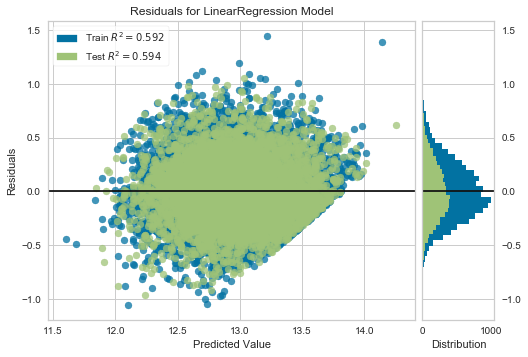

,coefficient
sqft_living_log,0.162171
sqft_living15_log,0.119072
years_old_log,0.013889
distance_downtown_log,-0.205216
waterfront,0.405850
renovated,0.110708
grade,0.186841
condition,0.187135
bath_2,0.024551
bath_3,0.034708


In [51]:
linear_regression(preprocessed)

This method lowers our R2 and overfits it on the training data - I don't think this model is particularly effective as compared to the one with one hot encoding.

### Model #5 

For our final model, we'll go back to using the one hot encoding method for transforming grade, condition, and bathrooms. In addition, we'll add in zipcodes. Zipcodes may be correlated somewhat with distance from downtown, but it should add some really good predictive power to the model. We'll treat zipcodes with the one hot coding method as well. There are 70 zipcodes, so there definitely will be some statistically insignificant coefficients, which we'll analyze and remove iteratively.

In [54]:
df8 = df.copy()

data_clean_zip(df8)
add_years_col(df8)
add_distance_col(df8)

df8.drop(df8[df8['distance_downtown'] > 40].index, inplace=True)

to_log = ['price', 'sqft_living', 'sqft_living15', 'years_old', 'distance_downtown']
vars_to_norm = ['sqft_living', 'sqft_living15', 'years_old', 'distance_downtown']
vars_no_norm = ['waterfront', 'renovated', ]
price = ['price_log']

df8['bathrooms'] = df8['bathrooms'].astype('int64')
one_hot_grade = pd.get_dummies(df8['grade'], prefix='grade', drop_first=True) 
one_hot_cond = pd.get_dummies(df8['condition'], prefix='cond', drop_first=True) 
one_hot_bath = pd.get_dummies(df8['bathrooms'], prefix='bath', drop_first=True)
one_hot_zip = pd.get_dummies(df8['zipcode'], prefix='zip')
one_hot_zip.drop(columns='zip_98103', inplace=True) #downtown waterfront zipcode which will be used as benchmark

df8.drop(columns=['grade', 'condition', 'bathrooms', 'zipcode'], inplace=True)

preprocessed = preprocessing(df8, to_log, vars_no_norm, price)
preprocessed = pd.concat([preprocessed, one_hot_grade, one_hot_cond, one_hot_bath, one_hot_zip], axis=1)
preprocessed.head()

,price_log,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,12.309982,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,13.195614,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.100712,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,13.311329,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.142166,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train Score: 0.827098757985521
Test Score: 0.8259948726646248
---
Train RMSE:  0.17695613770839586
Test RMSE:  0.17644213268468784
---
Unlogged Train RMSE:  81492.47657610319
Unlogged Test RMSE:  80329.8944993655
---
Intercept:  13.31133550660706


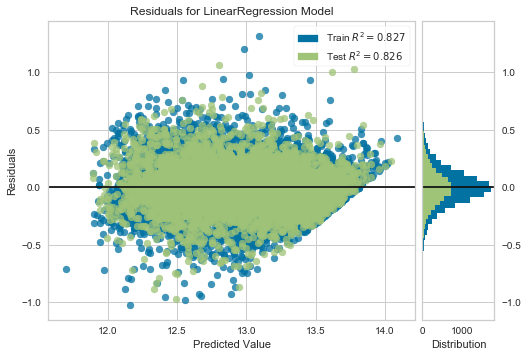

,coefficient
sqft_living_log,0.147790
sqft_living15_log,0.059765
years_old_log,0.009342
distance_downtown_log,-0.136621
waterfront,0.483844
...,...
zip_98177,-0.073597
zip_98178,-0.531572
zip_98188,-0.547806
zip_98198,-0.479509


In [55]:
#Let's run our linear regression, and then remove insignificant features
#This is definitely our best model, but it does seem to be slightly underfit

linear_regression(preprocessed)

Adding zipcodes substantially improves my R2 and RMSE, while fixing the previous under and overfit issues. This makes sense considering we've added 70 variables on top of what we've been using previously, but the zipcodes do seem to have decent predicitive power.

Let's remove the insignificant variables and run the model again. This is a bit easier in statsmodels, so let's run the regression in that library and cull our variables.

In [71]:
def sm_reg(df):
    '''
    Input: pandas dataframe
    Output: A new dataframe with insignificant variables removed.
    Insignificance is determined by P-Value in a statsmodels regression model. Any variable with a P-value
    over .05 is excluded from the new dataframe.
    '''
    outcome = 'price_log'
    predictors = df.drop('price_log', axis=1)
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    model = ols(formula=formula, data=df).fit()
    
    summary = model.summary()
    p_table = summary.tables[1]
    p_table = pd.DataFrame(p_table.data)
    p_table.columns = p_table.iloc[0]
    p_table = p_table.drop(0)
    p_table = p_table.set_index(p_table.columns[0])
    p_table['P>|t|'] = p_table['P>|t|'].astype(float)
    x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
    x_cols.remove('Intercept')
    print(len(p_table), len(x_cols))
    print(x_cols[:5])
    new_df = df[x_cols]
    return new_df

In [57]:
new_df = sm_reg(preprocessed)
new_df.head()

93 73
['sqft_living_log', 'sqft_living15_log', 'years_old_log', 'distance_downtown_log', 'waterfront']


,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,cond_2,...,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198
0,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We've removed 20 columns, let's run our regression again.

In [58]:
price_df = preprocessed['price_log']
preprocessed_2 = pd.concat([price_df, new_df], axis=1)
preprocessed_2.head()

,price_log,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,...,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198
0,12.309982,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,13.195614,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.100712,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,13.311329,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.142166,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train Score: 0.8107353827698286
Test Score: 0.8094548522076532
---
Train RMSE:  0.1837786403690176
Test RMSE:  0.1874079479410084
---
Unlogged Train RMSE:  85679.71203217041
Unlogged Test RMSE:  85854.38315022478
---
Intercept:  12.92660371944987


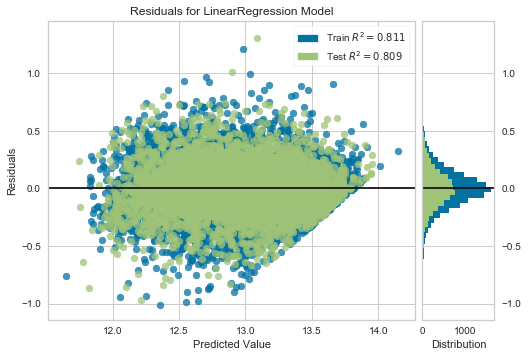

,coefficient
sqft_living_log,0.170724
sqft_living15_log,0.089680
years_old_log,-0.014712
distance_downtown_log,-0.137854
waterfront,0.595529
...,...
zip_98168,-0.651427
zip_98177,-0.082062
zip_98178,-0.564467
zip_98188,-0.575677


In [59]:
linear_regression(preprocessed_2)

Our R2 dropped slightly and the difference between the R2 increased slightly. Let's do one more round of feature elimination to see what we get.

In [60]:
new_df_2 = sm_reg(preprocessed)
new_df_2.head()

93 73
['sqft_living_log', 'sqft_living15_log', 'years_old_log', 'distance_downtown_log', 'waterfront']


,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,cond_2,...,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198
0,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
preprocessed_3 = pd.concat([price_df, new_df_2], axis=1)
preprocessed_3.head()

,price_log,sqft_living_log,sqft_living15_log,years_old_log,distance_downtown_log,waterfront,renovated,grade_4,grade_5,grade_6,...,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198
0,12.309982,-1.098580,-1.005237,0.714298,-0.444541,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,13.195614,0.964847,-0.209814,-0.371451,-0.259484,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.100712,-2.230189,1.421430,1.106469,0.105104,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,13.311329,0.246559,-0.954456,0.489566,-0.627857,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.142166,-0.162077,0.006329,-0.197627,0.494637,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train Score: 0.8107642708320564
Test Score: 0.8090699428630519
---
Train RMSE:  0.18468544982820312
Test RMSE:  0.18573996098139087
---
Unlogged Train RMSE:  85811.89399123793
Unlogged Test RMSE:  85490.3720548517
---
Intercept:  12.722742749966919


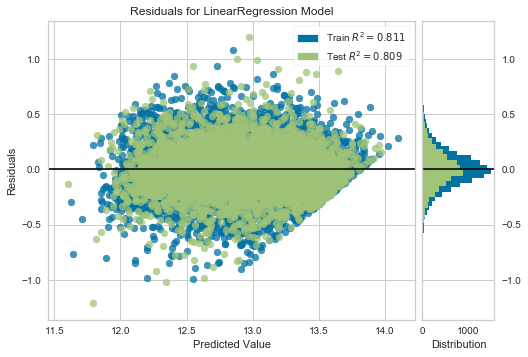

,coefficient
sqft_living_log,0.172522
sqft_living15_log,0.086783
years_old_log,-0.017589
distance_downtown_log,-0.139614
waterfront,0.544124
...,...
zip_98168,-0.656976
zip_98177,-0.086416
zip_98178,-0.579457
zip_98188,-0.564672


In [62]:
linear_regression(preprocessed_3)

This final model delivers our best measurements. We have nearly an identical Train and Test R2 and Train and Test RMSE.

Now that we have our model, let's use 5-fold cross validation

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
lr = LinearRegression()

cv_5_results_rmse = abs(np.mean(cross_val_score(lr, preprocessed_3.drop('price_log', axis=1), preprocessed_3['price_log'], 
                                           cv=5, scoring = 'neg_root_mean_squared_error')))
cv_5_results_r2 = np.mean(cross_val_score(lr, preprocessed_3.drop('price_log', axis=1), preprocessed_3['price_log'], 
                                           cv=5, scoring = 'r2'))

print('Cross Val R2:', cv_5_results_r2)
print('Cross Val RMSE:', cv_5_results_rmse)

Cross Val R2: 0.8076321280331668
Cross Val RMSE: 0.18595272519622952


On average, we get an R2 of .807 and an RMSE of .186.

In [64]:
sqft_living_coef = np.exp(0.174276)
sqft_living_coef

1.1903840664875358

In [65]:
sqft_living_15_coef = np.exp(.086408)
sqft_living_15_coef

1.0902510600061748

In [66]:
years_old_coef = np.exp(-0.013808)
years_old_coef

0.9862868931682736

In [67]:
distance_downtown_coef = np.exp(-0.136576)
distance_downtown_coef

0.872340019898728

In [70]:
waterfront_coef = np.exp(0.543188)
waterfront_coef

1.7214862215195663

In [69]:
renovated_coef = np.exp(0.0617)
renovated_coef

1.0636432038981334

## Evaluation

#### Benchmark Model:

- Train R2: 0.65
- Test R2: 0.66

- Train RMSE: 112,216
- Test RMSE: 110,609


#### Model 2:

- Train R2: 0.448
- Test R2: 0.455

- Train RMSE: 140,504
- Test RMSE: 142.561


#### Model 3:

- Train R2: 0.618
- Test R2: 0.628

- Train RMSE: 118,707
- Test RMSE: 116,058


#### Model 4a:

- Train R2: 0.625
- Test R2: 0.626

- Train RMSE: 117,421
- Test RMSE: 118,073

#### Model 4b:

- Train R2: 0.592
- Test R2: 0.593

- Train RMSE: 123,492
- Test RMSE: 122,259

#### Model 5:

- Train R2: 0.811
- Test R2: 0.809

- Train RMSE: 85,812
- Test RMSE: 85,490


#### Cross Val Score - Model 5:

- R2: 0.808
- RMSE: 0.189

Overall, our models improved as we iterated upon the benchmark model. By including the zipcodes in the final model, we got and R-squared of .809 for the test set and .812 for the train set - a slight overfit, but a nearly identical RMSE, demonstrating that our model is well fit. The model appears to generalize really well and would fit new unseen test data successfully.

In terms of a prediction engine, our model seems to provide significant accuracy. However, based on our visualizations alone, we have clearly not statisfied the assumptions of linear regression. We have a significant heteroscedasticity issue - our residual plot in nearly all models is cone-shaped at the higher price range. The distribution is mostly normal but suffers slightly on the high and low ends. 

Our model does generally satisfy the linearity and independence assumptions. Our continuous variables are linearly related to price aside from years old. We also took care of multicollinearity by removing variables, such as sqft_above and sqft_below, and by scaling the variables to remove structural multicollinearity. Because of these satisified assumptions, we generally rely on the various coefficients. Particularly, if we hadn't resolved collinearity, we would not be able to accept the individual coefficients as valid.

As a final step, let's review the coefficients for some of our independent variables in our Model 5:

- sqft_living: 0.17 = exp(0.174276) = 1.19
    - A one unit increase in the square footage of a home increases price by 19% on average, holding all else equal.
- sqft_living15: .086 = exp(.086408) = 1.09
    - A one unit increase in the square footage of your 15 closest neighbors increases price by 9% on average.
- years_old: -0.014 = exp(-0.013808) = .986
    - An extra year of age decreases price by an average of about 1.4%.
- distance_downtown: -0.14 = exp(-0.136576) = .87
    - One extra mile further from downtown decreases price by an average of about 13%.
- waterfront: -.51 = exp(0.543188) = 1.72
    - A house on the waterfront is 72% more expensive than a house that isn't, on average.
- renovated: .0617 = exp(0.0617) = 1.06
    - A renovated house is 6% more expensive than a house that hasn't been renovated, on average.
    
    
These are insightful findings. All of these coefficients have the expected effect in terms of the direction they move price. For example, one would have assumed before running this analysis that waterfront homes are more expensive, and our data shows that they are, by a staggering 72%. We also would have expected age and distance from downtown Seattle to have negative impacts, which the data bears out. 1% seems small for each additional year, but it could add up quickly. For example, a home that's 10 years older than another would be exp(10*-0.013808) = .87 - meaning that older house is 13% cheaper than the other, holding all else equal. And each additional mile from downtown leads to a 13% decrease in price. This information could be really beneficial to a potential buyer. Would they be willing to trade an extra mile from downtown for perhaps extra square footage, or for a younger house? This data could go a long way in making sound buying decisions.

## Conclusions

As stated above, our final model, which included zipcodes, is the most robust in terms of R2 and RMSE, our primary metrics for determining goodness of fit and accurate predictions. Any potential buyer could use this information as a way to figure out which home is right for them. How would one balance a desire to live closer to downtown with wanting more square footage? Or wanting a newer home, but that home is a bit farther for the city center than they'd like?

Our models do have some limitations, mainly dealing with hidden variable bias. In the future, we would need to take in significantly more data to create a model useful enough for an application that people can rely on. One could imagine how many other factors there are in predicting home price. There are the factors mentioned earlier, like proximity to schools and walkability, but there are also factors like the job market (% unemployment, number of openings, primary industries), types of schools (colleges/universities, community colleges) nearby, number of eateries, etc. The list goes on. A more successful model would incorporate the most influential of these other variables. These hidden variables also limit the extent to which we can rely on the interpretations of the coefficients.

So future work would primarily deal with creating a more robust set of data. Doing so would allow for the creation of a really successful app that potential home buyers could count on to help find good deals.